In [1]:
import numpy as np
import matplotlib.pyplot as plt


TASK_E - a

In [2]:
def create_sequence():
    sample_rate = 128
    # Sampling step
    step = 1.0 / sample_rate
    timeline = np.arange(0, 1, step)
    signal = 3
    signal += 1 * np.sin(2 * np.pi * 1 * timeline)
    signal += 0.5 * np.sin(2 * np.pi * 5 * timeline)
    signal += 0.05 * np.sin(2 * np.pi * 15 * timeline)
    return signal


In [3]:
def create_dft_matrix(signal):
    length = signal.shape[0]
    idx = np.arange(length)
    freq = idx.reshape((length, 1))
    matrix = np.exp(-2j * np.pi * freq * idx / length)
    return matrix


In [4]:
signal = create_sequence()
dft_matrix = create_dft_matrix(signal)

dft_result = np.dot(dft_matrix, signal)
dft_result.shape


(128,)

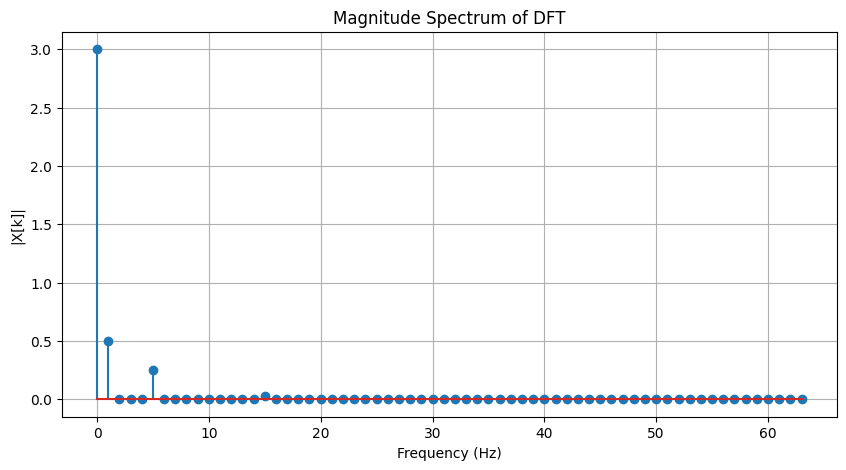

In [5]:
length = len(signal)
magnitude = np.abs(dft_result) / length
frequency_axis = np.fft.fftfreq(length, 1/128)

half_length = length // 2
plt.figure(figsize=(10,5))
plt.stem(frequency_axis[:half_length], magnitude[:half_length])
plt.xlabel("Frequency (Hz)")
plt.ylabel("|X[k]|")
plt.title("Magnitude Spectrum of DFT")
plt.grid(True)
plt.show()


- Yes the Peak amplitude correspond to the amplitudes of that particular frequencies.
- There are peaks at 0 Hz, 1 Hz, 5 Hz, 15 Hz with amplitudes 3, 1, 0.5, 0.05 as expected.

TASK_E - b

In [6]:
def generate_shifted_samples():
    sr = 128
    # Sampling interval
    ts = 1.0/sr
    t = np.arange(0,1,ts)
    x = 3
    x += 1*np.sin(2.1*np.pi*1*t)
    x += 0.5*np.sin(2*np.pi*5*t)
    x += 0.05*np.sin(2*np.pi*15*t)
    return x

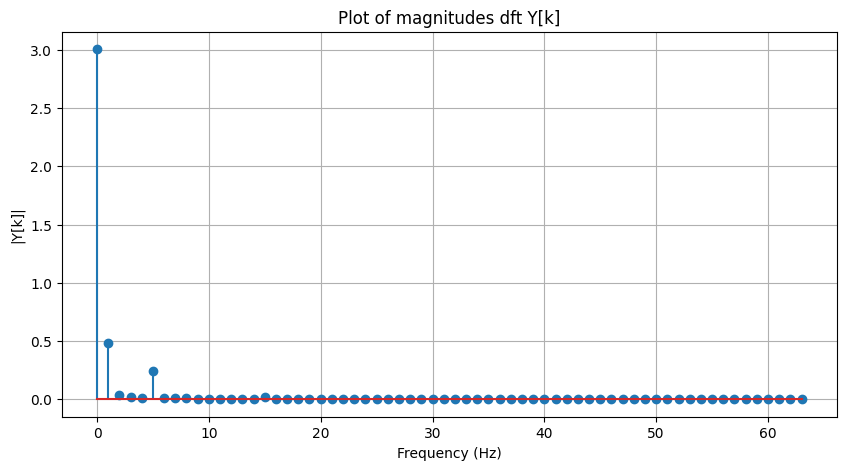

In [8]:
y = generate_shifted_samples()
F = create_dft_matrix(y)

dft_y = np.dot(F,y)
n = len(y)
mag = np.abs(dft_y) / n
freqs = np.fft.fftfreq(n,1/128)

half_N = n//2
plt.figure(figsize=(10,5))
plt.stem(freqs[:half_N], mag[:half_N])
plt.xlabel("Frequency (Hz)")
plt.ylabel("|Y[k]|")
plt.title("Plot of magnitudes dft Y[k]")
plt.grid(True)
plt.show()

- The DFT represents a signal as a sum of sinusoids whose frequencies are integer multiples of the fundamental frequency bin spacing.
$$
\Delta f = \frac{f_s}{N}
$$

- We took number of samples N = 128 and , sampling rate = 128, therefore $\Delta f = 1$

- But the sinusoid sin(2.1πt) has a frequency of 1.05 Hz, and cannot be represented by exact one peak. Therefore the energy is spread to multiple nearby slots , creating a spread or broadened peak.

- This is called spectral Leakage


TASK_E - c

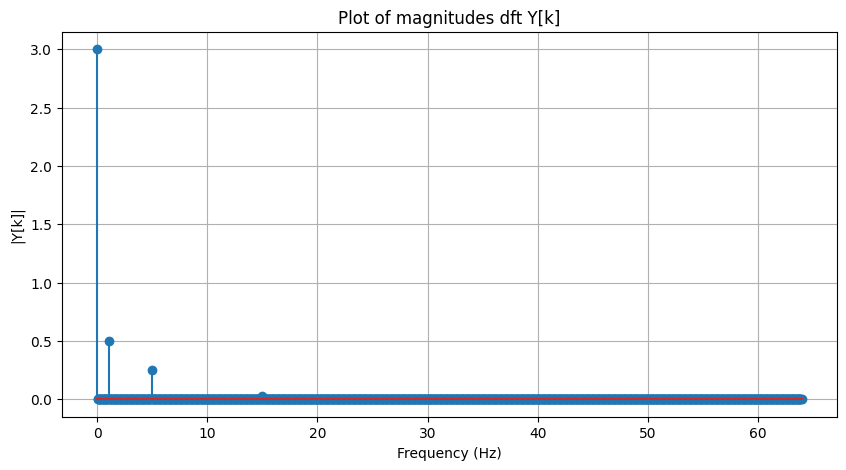

In [10]:
def generate_shifted_samples(N=128, fs=128):
    ts = 1.0 / fs
    T = N * ts
    t = np.linspace(0, T, N, endpoint=False)

    x = 3 \
        + np.sin(2.1*np.pi*t) \
        + 0.5*np.sin(10*np.pi*t) \
        + 0.05*np.sin(30*np.pi*t)

    return t, x

t, y = generate_shifted_samples(2560,128)
F = create_dft_matrix(y)

dft_y = np.dot(F,y)
n = len(y)
mag = np.abs(dft_y) / n
freqs = np.fft.fftfreq(n,1/128)

half_N = n//2
plt.figure(figsize=(10,5))
plt.stem(freqs[:half_N], mag[:half_N])
plt.xlabel("Frequency (Hz)")
plt.ylabel("|Y[k]|")
plt.title("Plot of magnitudes dft Y[k]")
plt.grid(True)
plt.show()

- To improve frequency resolution such that a tone at $1.05\ \text{Hz}$ aligns exactly with a DFT bin (avoiding leakage into neighboring bins), we must carefully choose the number of samples and the sampling frequency so that the bin spacing $\Delta f$ matches the smallest distinguishable frequency unit required.

- The DFT bin spacing is
  $$
  \Delta f = \frac{f_s}{N},
  $$
  where $f_s$ is the sampling rate and $N$ is the number of samples (so total duration $T = N/f_s$).

- Why $N=2560$ with a sampling rate $f_s=128\ \text{Hz}$ ? :  
  With $f_s=128$ and $N=2560$,
  $$
  \Delta f = \frac{128}{2560} = 0.05\ \text{Hz}.
  $$
  For the tone at $f_0=1.05\ \text{Hz}$ the DFT bin index is
  $$
  k = \frac{f_0}{\Delta f} = \frac{1.05}{0.05} = 21,
  $$
  which is an integer. Therefore the $1.05\ \text{Hz}$ component lies exactly on bin $k=21$, so a single peak at that bin is sufficient to represent that frequency. Therefore its energy is concentrated in that single bin (no bin-mismatch), producing a sharp peak and eliminating the spectral spreading caused by bin misalignment.

- When compared to the previous plot, we can see that no other peak is visible around the frequency $1.05\ \text{Hz}$

- $N=2560$ at $f_s=128$ means total duration
  $$
  T = \frac{N}{f_s} = \frac{2560}{128} = 20\ \text{seconds}.
  $$
  A longer observation time gives finer frequency resolution ($\Delta f = 1/T$), which is the fundamental reason leakage is reduced.

- **The tradeoffs are :**
  - **Duration vs. resolution:** Improving resolution requires larger $T$ (or larger $N$ at fixed $f_s$) since $\Delta f = 1/T$. Longer recordings give better ability to separate closely spaced frequencies.
  - **Computation & memory:** larger $N$ increases FFT cost ($O(N\log N)$) and memory usage, therefore can be impractical and inefficient for very large $N$.
  - **Stationarity assumption:** longer durations assume the signal is stationary over $T$. If the signal changes in time, very long $T$ can blur time-varying behavior.
  - **Sampling rate $f_s$ role:** increasing $f_s$ (with fixed $T$) does **not** improve $\Delta f$, it only extends the Nyquist range. To improve $\Delta f$ we must increase $T$ the time period (or $N$ the number of samples).
  - **Alternatives when long recording is impossible:**  
    - **Zero-padding** (increase FFT length) interpolates the spectrum for better visual peak localization but does not increase true resolution (it does not reduce leakage).  
    - **Windowing** (Hann/Hamming) reduces sidelobes (less leakage) but slightly widens main lobes — a trade between sidelobe level and peak width.

- Choosing $N=2560$ with $f_s=128$ yields $\Delta f=0.05\ \text{Hz}$, which places the $1.05\ \text{Hz}$ sinusoid exactly on an FFT bin ($k=21$). This alignment removes bin-mismatch for that tone, concentrates its energy into a single bin, and therefore produces a sharp, high peak in the DFT rather than a smeared pattern across many bins.
